In [32]:
# Import useful things

import numpy as np      
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import rcParams
import matplotlib.dates as md
import os
import glob
import sys
sys.path.append('/Users/heather/ICECAPS-ACE/DataParse/')

from ace_parse import *
from utils import * 

# Plotting preferences:
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 14}) 
rcParams['axes.titlepad'] = 16 
rcParams['xtick.major.pad']='12'
rcParams['ytick.major.pad']='12'

# Supress warnings for notebook ease of use
import warnings
warnings.filterwarnings("ignore")

In [18]:
# Merge all the hourly netcdfs for that day. 
import netCDF4
from netCDF4 import Dataset

# MMCR data location
dloc = '/Volumes/Data/ICECAPSarchive/Nephelometer/'

# years
years = [2011,2012,2013,2014,2015,2016,2017,2018,2019]



sc_dfs=[]
ab_dfs=[]

for year in years: 
    start = dt.datetime(year,1,1,0)
    stop = dt.datetime(year,12,31,23)
    os.chdir(dloc)                  # Change directory to where the data is

    nc = netCDF4.Dataset(glob.glob(dloc + 'ESRL-GMD-AEROSOL_v1.0_HOUR_SUM_s%s0101T000000Z_e%s0101T000000Z*'%(year,year+1))[0],'r')
    time_raw = nc.groups['data'].variables['time']
    time = netCDF4.num2date(time_raw[:],time_raw.units)

    # Absorption
    ab_group = nc.groups['data'].groups['light_absorption']
    ab_wavelengths = ab_group.variables['wavelength'][:]      # Central measurement wavelength (nm), 3D
    ab_coef = ab_group.variables['absorption_coefficient'][:] # Absorption coefficient at ST (M/m) [wavelength, time]
    ab_cutsize = ab_group.variables['cut_size'][:]              # Maximum aerodyamic particle diameter (um), 1D

    # Scattering
    sc_group = nc.groups['data'].groups['light_scattering']
    sc_wavelengths = sc_group.variables['wavelength'][:]      # Central measurement wavelength. 
    sc_coef = sc_group.variables['scattering_coefficient'][:]    # Backwards hemispheric scatering coefficent at STP (M/m)
    sample_pres = sc_group.variables['sample_pressure'][:]       # %
    sample_humid= sc_group.variables['sample_humidity'][:]       # hPa
    sample_T= sc_group.variables['sample_temperature'][:]        # degC
    sc_cutsize = sc_group.variables['cut_size'][:]            # Maximum aerodyamic particle diameter (um), 1D

    # Put in pandas dataframe

    sc_df = pd.DataFrame({'Time':time})
    sc_df = sc_df.set_index('Time')
    sc_df.index = pd.DatetimeIndex(sc_df.index)
    for i in range(0,len(sc_wavelengths)):
        sc_df['%s'%sc_wavelengths[i]]=sc_coef[i,:]

    sc_dfs.append(sc_df)

    ab_df = pd.DataFrame({'Time':time})
    ab_df = ab_df.set_index('Time')
    ab_df.index = pd.DatetimeIndex(ab_df.index)
    
    try:
        for i in range(0,len(ab_wavelengths)):
            ab_df['%s'%ab_wavelengths[i]]=ab_coef[i,:]    
    except:
        ab_df['%s'%ab_wavelengths]=ab_coef[:]
    
    
    ab_dfs.append(ab_df)
    


In [19]:
# Join data frame
all_sc = pd.concat(sc_dfs)
all_ab = pd.concat(ab_dfs)

all_sc['QC'] = np.ones(len(all_sc))
all_ab['QC'] = np.ones(len(all_ab))

In [20]:
# QC

# QC for north winds (has to be done before flight dates else risks getting overwritten)
for year in years: 
    print('QCing %s for north winds'%year)
    w_dloc = '/Volumes/Data/ICECAPSarchive/Summit_Met_hourly/met_sum_insitu_1_obop_hour_%s.txt'%year
    met = get_NOAA_met(w_dloc)
    met['temp_QC'] = np.ones(len(met))
    met['temp_QC'][met['ws']<1]=0
    met['temp_QC'][met['wd']<72]=0
    met['temp_QC'][met['wd']>342]=0

    all_sc['QC'].loc[met['temp_QC'].index.strftime(date_format='%Y%m%d%H%M')[0] : met['temp_QC'].index.strftime(date_format='%Y%m%d%H%M')[-1]] = met['temp_QC']
    all_ab['QC'].loc[met['temp_QC'].index.strftime(date_format='%Y%m%d%H%M')[0] : met['temp_QC'].index.strftime(date_format='%Y%m%d%H%M')[-1]] = met['temp_QC']  
    
    

    

QCing 2011 for north winds
QCing 2012 for north winds
QCing 2013 for north winds
QCing 2014 for north winds
QCing 2015 for north winds
QCing 2016 for north winds
QCing 2017 for north winds
QCing 2018 for north winds
QCing 2019 for north winds


In [21]:

# Make sure there are no duplicates
all_sc = all_sc.drop_duplicates()
all_ab = all_ab.drop_duplicates()

# Just look at QC data
sc_qc = all_sc.copy()
ab_qc = all_ab.copy()

sc_qc[sc_qc['QC']!=1]=np.nan
ab_qc[ab_qc['QC']!=1]=np.nan


# clean
ab_qc[ab_qc>1000]=np.nan

# Calculate monthly medians. 
monthly_med_sc = sc_qc.resample('1M').median()
monthly_med_ab = ab_qc.resample('1M').median()
months_sc = monthly_med_sc.index - pd.Timedelta(days=15)
months_ab = monthly_med_ab.index - pd.Timedelta(days=15)

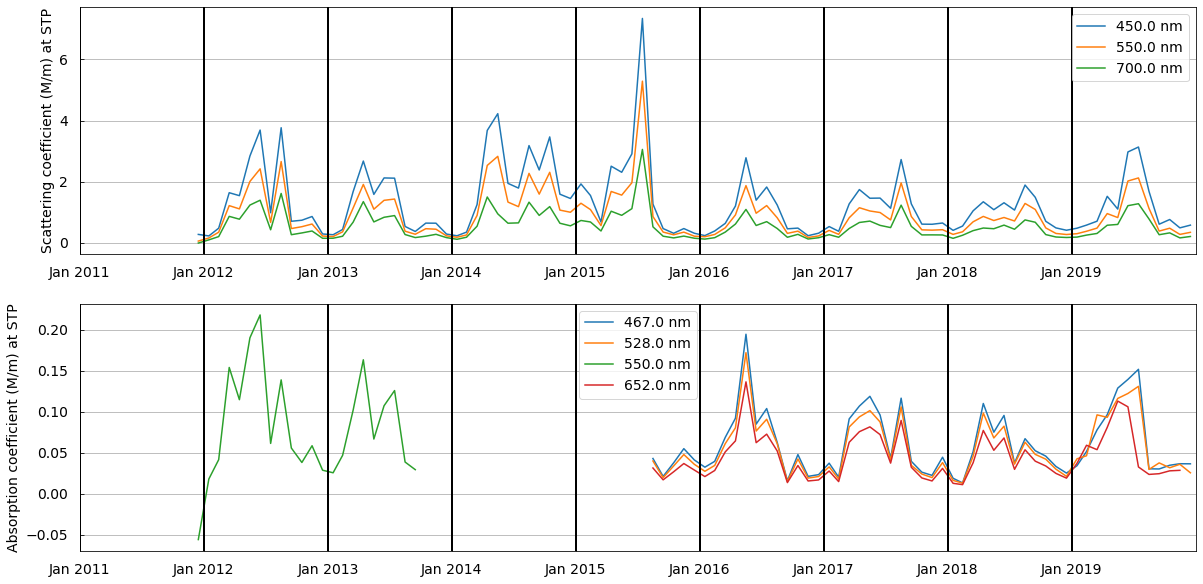

In [34]:

# Plot qc'd

fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(211)
for i in range(0, np.shape(monthly_med_sc)[1]-1):
    ax1.plot(months_sc,monthly_med_sc[monthly_med_sc.keys()[i]],label='%s nm'%monthly_med_sc.keys()[i]) 

ax1.set_ylabel('Scattering coefficient (M/m) at STP')
ax1.xaxis.set_major_formatter(md.DateFormatter('%b %Y'))
ax1.xaxis.set_major_locator(md.MonthLocator(interval=12))


# Plot january's
for i in range(0,len(years)):
    ax1.axvline(dt.datetime(years[i],1,1,0),c='k',lw=2)

#ax1.set_ylim(0.5,100)
#ax1.set_yscale('log')
ax1.set_xlim(dt.datetime(years[0],1,1,0),dt.datetime(years[-1],12,31,23))
ax1.grid('on')
ax1.legend()


ax2 = fig.add_subplot(212)
for i in range(0, np.shape(monthly_med_ab)[1]-1):
    ax2.plot(months_ab,monthly_med_ab[monthly_med_ab.keys()[i]],label='%s nm'%monthly_med_ab.keys()[i]) 

# Plot january's
for i in range(0,len(years)):
    ax2.axvline(dt.datetime(years[i],1,1,0),c='k',lw=2)
    
ax2.set_ylabel('Absorption coefficient (M/m) at STP')
ax2.xaxis.set_major_formatter(md.DateFormatter('%b %Y'))
ax2.xaxis.set_major_locator(md.MonthLocator(interval=12))
#ax2.set_ylim(0.1,5)
#ax2.set_yscale('log')
ax2.set_xlim(dt.datetime(years[0],1,1,0),dt.datetime(years[-1],12,31,23))
ax2.grid('on')
ax2.legend()

#ax2.xaxis.set_major_locator(md.DayLocator(bymonthday=1))
#ax1.xaxis.set_major_locator(md.HourLocator(interval=3))


In [23]:
# Single-scattering albedo (SSA)
# The ratio of scattering to extinction, indicative of aerosol darkness
# White aerosols (i.e. sea salt) have higher SSA
# Dark aerosols (i.e. black carbon) have lower SSA values. 
# a value of unity implies that all particle extinction is due to scattering; 
# conversely, a single-scattering albedo of zero implies that all extinction is due to absorption.

# SSA = sc / (sc + ab)
# Using 550 nm as in Schmeisser et al 2018)

SSA = monthly_med_sc['550.0'] / (monthly_med_sc['550.0'] + monthly_med_ab['528.0'])


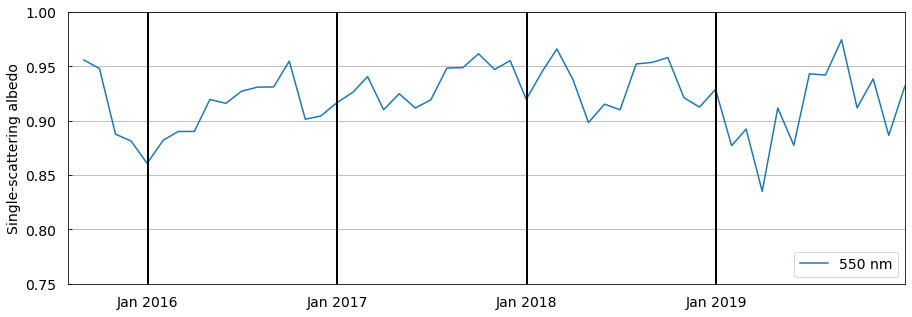

In [38]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(111)
ax1.plot(SSA,label='550 nm') 
#ax1.plot(time,sc_coef[1,:],label='%s nm'%int(sc_wavelengths[1])) 
#ax1.plot(time,sc_coef[2,:],label='%s nm'%int(sc_wavelengths[2]))
ax1.set_ylabel('Single-scattering albedo')

ax1.set_ylim(0.75,1)
#ax1.set_yscale('log')

# Plot january's
for i in range(0,len(years)):
    ax1.axvline(dt.datetime(years[i],1,1,0),c='k',lw=2)

ax1.set_xlim(dt.datetime(2015,8,1,0),dt.datetime(years[-1],12,31,23))
ax1.grid('on')
ax1.legend()

ax1.xaxis.set_major_formatter(md.DateFormatter('%b %Y'))
ax1.xaxis.set_major_locator(md.MonthLocator(bymonth=1))
#ax1.xaxis.set_major_locator(md.HourLocator(interval=3))